# Toxic Comment Classification

Group Project for MSDS621 Machine Learning at University of San Francisco. 

Kaggle competition link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Team members include:
- Xinran (Grace) Zhang
- Shivee Singh
- Neha Tevathia
- Tianqi Wang
- Meng-Ting(Joyce) Chang

<a id='table-of-content'></a>
## Table of Content


1. [Overview](#Overview)

2. [Required Libraries](#Libraries)
2. [Explanatory Data Analysis](#EDA)
 - [Data Loading](#Data-loading)
 - [Data Analysis](#Data-Analysis)

3. [Feature Engineering](#Feature-engineering)
4. [Modeling and Evaluation](#Modeling)
 - [Cross Validation](#cv)
 - [Model Comparison](#model-comparison)
 - [Pipeline](#pipeline)
5. [Hyperparameters Tuning](#Tuning)
 - [Logistic Regression](#lr-tuning)
 - [Naive Bayes](#nb-tuning)
 - [SVM](#svm-tuning)
 - [Random Forest](#rf-tuning)
6. [Ensembling](#Ensembling)
 - [Boosting](#Boosting)
 - [Voting](#Voting)
7. [Results Interpretation](#Interpretation)


<a id='overview'></a>
## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.


<a id='Libraries'></a>
## Packages Loading

In [1]:
import pandas as pd
import numpy as np
import re, string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='EDA'></a>
## Data Preprocessing and Exploratory Data Analyasis

### 📥 Data Loading

In [2]:
train  = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
test_y  = pd.read_csv("data/test_labels.csv")

### Data Analysis

In [ ]:
train.head()

In [ ]:
train.describe()

In [ ]:
test.head()

In [ ]:
test_y.head()

Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [ ]:
train.shape

In [ ]:
test.shape

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

In [ ]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len() 
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [3]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

In [ ]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

In [ ]:
# Code to draw bar graph for visualising distribution of classes within each label. 
barWidth = 0.25

bars1 = [sum(train['toxic']==1), sum(train['obscene']==1), sum(train['insult']==1), sum(train['severe_toxic']==1),
              sum(train['identity_hate']==1), sum(train['threat']==1)]
bars2 = [sum(train['toxic']==0), sum(train['obscene']==0), sum(train['insult']==0), sum(train['severe_toxic']==0),
              sum(train['identity_hate']==0), sum(train['threat']==0)]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 
                                                      'Threat'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [ ]:
# example of clean comment
train.comment_text[0]

In [ ]:
# example oftoxic comment
train[train.toxic==1].iloc[1,1]

It might be a great practice to see which labels are likely to appear together with a comment.

In [ ]:
# Cross correlation matrix across labels
rowsums = train.iloc[:,2:].sum(axis=1)
temp = train.iloc[:,2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [ ]:
def W_Cloud(token):
    threat_context = train[train[token] == 1]   
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')             
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

In [ ]:
token = input('Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

<a id='Feature-engineering'></a>
## Feature-engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [4]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [5]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.

    '''
    text=text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    #remove any non ascii 
    words=[word.encode('ascii','ignore').decode('ascii') for word in words]
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    words=[w for w in words if len(w)>2]
    return words

#### Benchmarking Different Vectorizer

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Besides TFIDF, we also tried CountVectorizer. However, it is not performing as well as TFIDF. The TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or TermFrequency-InverseDocumentFrequency representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. That's why we can improve the accuracy here.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TFIDF worked better than CountVectorizer.

In [6]:
# Creating a TFIDF vectorizer and using custom tokenizer defined above.
#using min_df to get rid of uncommon tokens such as usernames, ip address and misspelled words, meaningless words.
vector = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10) 
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

After the transformation, we can take a look at some of the features below.

In [7]:
vector.get_feature_names()[0:20]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

<a id='Modeling'></a>
## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus we choose to compare Multinomial Naive Bayes with Logistic Regression, and Linear Support Vector Machine.

### Evaluation Metrics

**NEED TO FILL IN MORE CONTENTS** - explaining which evaluation metrics we will be using and which one we will be using to compare models.

<a id='cv'></a>
### Cross Validation

We use K-fold Validation to compare between the baseline model and the other three models that we have chose.

In [8]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [9]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the k fold cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    
    for label in test_labels:
        recall=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1=cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='f1')
        methods.append([name,label,recall.mean(), f1.mean()])

    return methods

In [10]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv=pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv=pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv=pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [11]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model','Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model','Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.483066,0.636650
1,MultinomialNB,severe_toxic,0.021336,0.041091
2,MultinomialNB,obscene,0.469168,0.622147
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367144,0.511521
5,MultinomialNB,identity_hate,0.007837,0.015355
6,LogisticRegression,toxic,0.610500,0.731340
7,LogisticRegression,severe_toxic,0.256395,0.351711
8,LogisticRegression,obscene,0.636997,0.747361
9,LogisticRegression,threat,0.125665,0.210778


Based on the cross validation above, we noticed that overall, the linear SVC model and Logistic Regression model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the `threat` label and `identity_hate` label because these two labels as the least number of observations.

Now we want to see how these three models perform on the actual prediction - the test dataset.

### ⚔ Modeling and Evaluation

In [12]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
        
        predict_df[label] = predicted

        recall=recall_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        f1=f1_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])

        conf_mat = confusion_matrix(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        methods.append([name,label,recall,f1,conf_mat])
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    hloss.append([name, hamming_loss_score])
    
    return hloss, methods

In [13]:
#Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [14]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.532841,0.610192
1,MultinomialNB,severe_toxic,0.062670,0.114428
2,MultinomialNB,obscene,0.455432,0.586736
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.368252,0.497536
5,MultinomialNB,identity_hate,0.002809,0.005594
6,LogisticRegression,toxic,0.710181,0.677793
7,LogisticRegression,severe_toxic,0.302452,0.334842
8,LogisticRegression,obscene,0.609591,0.673854
9,LogisticRegression,threat,0.156398,0.229167


In [15]:
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.532841,0.610192
1,MultinomialNB,severe_toxic,0.062670,0.114428
2,MultinomialNB,obscene,0.455432,0.586736
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.368252,0.497536
5,MultinomialNB,identity_hate,0.002809,0.005594
6,LogisticRegression,toxic,0.710181,0.677793
7,LogisticRegression,severe_toxic,0.302452,0.334842
8,LogisticRegression,obscene,0.609591,0.673854
9,LogisticRegression,threat,0.156398,0.229167


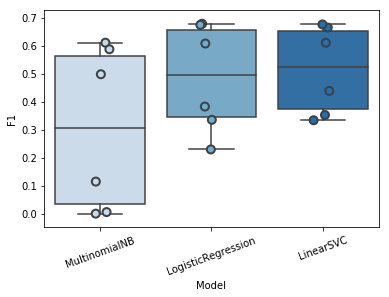

In [16]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods, 
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(),rotation=20)

plt.show()

Above are the result table and plot showing a comparison between these three different models after training the models and see how these models perform on the test data.

Notice that Muninomial Naive Bayes does not perform as well as the other two models while Linear SVC in general out performs the others based on F1 score.

### Visualzing performance till now for each classifier across each category

Plot for Multinomial Naive Bayes regression


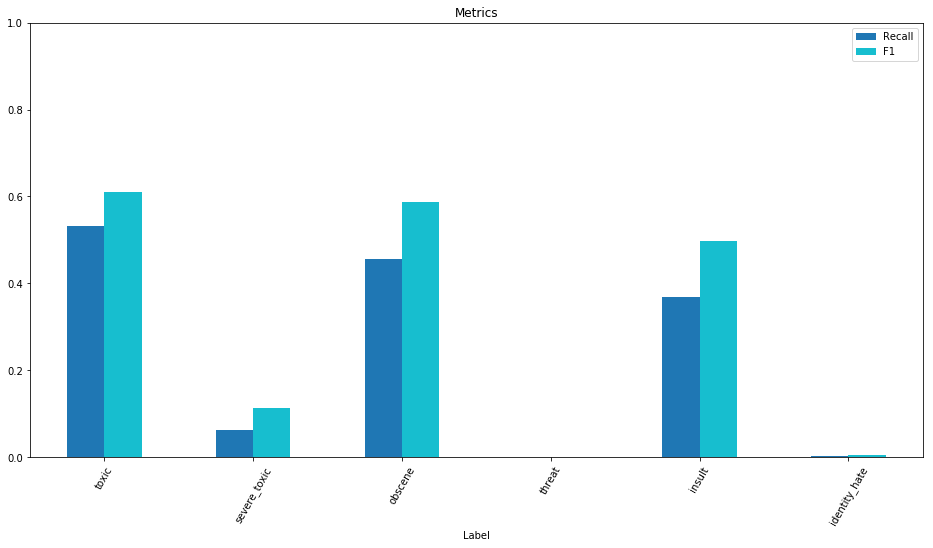

In [17]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model=='MultinomialNB']

m2.set_index(["Label"],inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

Plot for Logistic regression


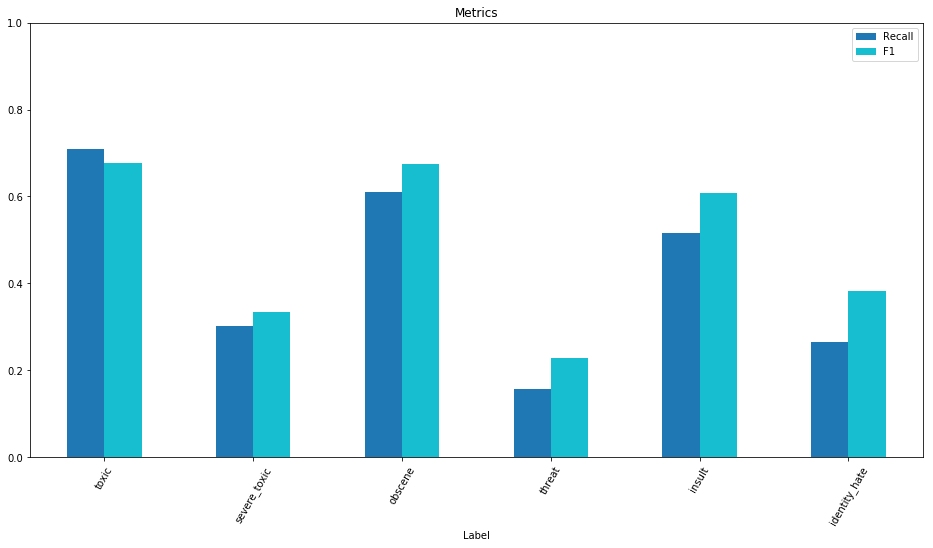

In [18]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model=='LogisticRegression']

m2.set_index(["Label"],inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

Plot for Linear SVC


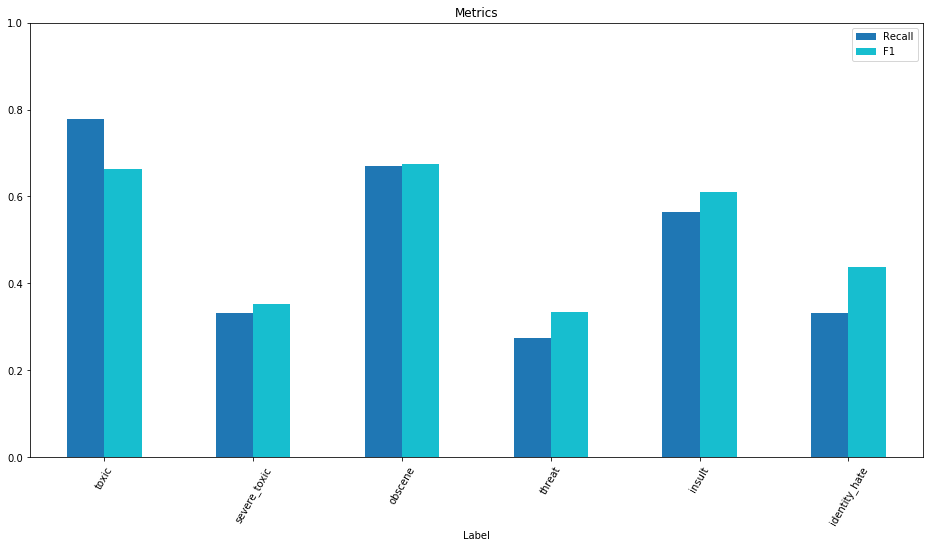

In [19]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model=='LinearSVC']

m2.set_index(["Label"],inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

<a id='model-comparison'></a>
####  Visualzing performance till now for each classifier for 'Toxic' label using Confusion Matrix

In [20]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
           annot=True,
           annot_kws={"size": 16},
           cmap="Blues",
           fmt='.2f',
           linewidths=2, 
           linecolor='steelblue',
           xticklabels=("Non-toxic","Toxic"),
           yticklabels=("Non-toxic","Toxic"))

    plt.ylabel('True',fontsize=18)
    plt.xlabel('Predicted',fontsize=18)
    plt.show()

In [21]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic":0, "severe_toxic":1, "obscene":2, "threat":3, "insult":4, "identity_hate":5}
    
    pos = labels[label]
    for i in range(pos,len(meth),6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label `toxic`. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

Choose a class for the Confusion Matrix: toxic
*************** toxic labelling ***************

****  MultinomialNB  ***


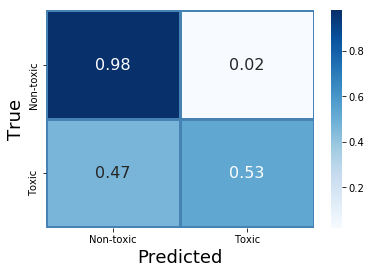


****  LogisticRegression  ***


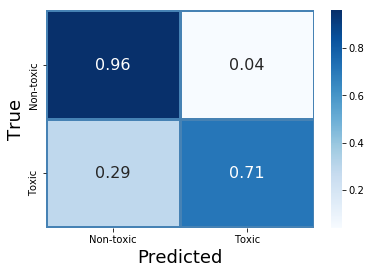


****  LinearSVC  ***


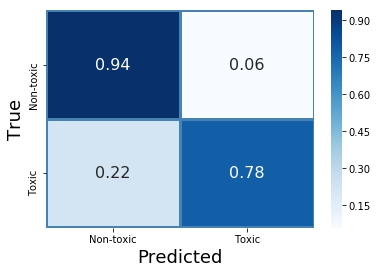

In [22]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, **LinearSVC performs better than anyone for 'toxic' label .**




### To get aggregate score we chose Hamming loss as our metric


In [23]:
#Creating a dataframe to summarize Hamming-loss 
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [24]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026939
1,LogisticRegression,0.025675
2,LinearSVC,0.028476


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.

<a id='pipeline'></a>
### Pipelines
So far we have only compared models without any hyperparameter tuning. Let's clean the code with pipeline and use some manually chosen hyperparameters to check how each model behaves. Since the greatest concern now is the imbalanced data, we decide to manually adjust `class_weight` for the models to see if we can achieve better results.

Since Logistic Regression and Linear SVM are performing better. We will focus on these two models. For display purpose, we will only include average F1 score, Recall, and Hamming Loss for comparison.

In [28]:
# Create a pipeline for each classifier. 
#We are using same TFIDF vectorizer across all models hence not adding it to pipeline.
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced")) # to account for class imbalance
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight = {1:20}))
])
  
pipelines = [pipe_lr, pipe_linear_svm]

In [29]:
# Iterate over each pipeline and each label to calculate metrics of interest
score_df = []
for pipe in pipelines:
    f1_values = [] 
    recall_values = []
    hl = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        pipe.fit(X_train, train[label])
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted
    
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
    val = [name, mean(f1_values), mean(recall_values), hamming_loss_score]
    score_df.append(val)  

In [27]:
# Shows mean score for each classifier
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1', 'Recall', 'Hamming_Loss']
scores

,Model,F1,Recall,Hamming_Loss
0,LogisticRegression,0.406536,0.885334,0.065950
1,LinearSVC,0.446147,0.741886,0.058366


Notice that after adjusting `class_weight`, we are getting way better results than the basic models. The F1 score of Logistic Regression model has jumped to an average of 0.885 while Linear SVC has jumped to 0.74

<a id='Tuning'></a>
## Hyperparameter Tuning 

Now we decide to do grid search to seek for the "optimal" hyperparameters for the basic models that we've chose. Later we will make comparison based on the best model from each algorithm, since we have 6 different lables, tuning models for each label would be time expensive, so we will use the most common label "Toxic" to tune hyperparameters.

### Multinomial Naive Bayes Tuning

In [ ]:
naive_bayes_classifier = MultinomialNB()

parameter_grid = {'alpha': [0.1, 1, 10, 100]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(naive_bayes_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, train['toxic'])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

<a id='lr-tuning'></a>
### Logistic Regression Tuning

In [39]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                 'class_weight':[None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, train['toxic'])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_


Best score: 0.9565898565528824
Best parameters: {'class_weight': None, 'solver': 'liblinear'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

<a id='svm-tuning'></a>
### SVM Classifier Tuning

In [ ]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight':[None, 'balanced'],
                  'C': [1,5,10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, train['toxic'])
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Grid Search results showed that with hyperparameters as follows, the Logistic Regression model can achieve a best score of 0.9566.

`LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',tol=0.0001, verbose=0, warm_start=False)`

With hyperparameters as follows, the Linear SVC model can achieve a best score of 0.9585.

`LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,verbose=0)`

### PLACEHOLDER FOR MODEL SELECTION

<a id='Ensembling'></a>
## Ensembling 

Since Ensemble learning helps improve machine learning results by combining several models and allows the production of better predictive performance compared to a single model, we want to see if Ensembling could help us achieve better results. 

To ensemble different models, we firstly tried some models based on tree boosting, then use a voting classfier to ensemble one of the boosting model with the basic models in previous parts.

<a id='boosting'></a>
### Boosting Models

We tried 4 popular tree-based boosting models, and make a comparison for those models.

In [ ]:
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [ ]:
score_df = []
for model in boosting_models:
    f1_values = [] 
    recall_values = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for idx,label in enumerate(test_labels):
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
        name = model.__class__.__name__
    
    hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
    val = [name, mean(f1_values), mean(recall_values), hamming_loss_score]
    score_df.append(val)  

### Scores After Boosting the Model

In [ ]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1','AUC','F2','Recall', 'Hamming_Loss']


#### AdaBoost and Gradient Boosting both have almost equal performance with GBoost performing slighlt better.

<a id='voting'></a>
### Voting
Ensembling with Gradient Boosting since it performed the best.

In [ ]:
nb_clf = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf),
                                            ('nb', nb_clf),
                                            ('svm', svm_clf),
                                            ('rf', rf_clf), 
                                            ('gb', gb_clf)], voting='hard')
score_df = []
f1_values = [] 
auc_values = []
f2_values = []
recall_values = []
hl = []
predict_df = pd.DataFrame()
predict_df['id'] = test_y['id']
for label in test_labels:
    ensemble_clf.fit(X_train, train[label])
    predicted = ensemble_clf.predict(X_test)

    predict_df[label] = predicted

    auc_values.append(roc_auc_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
    f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]'))
    f2_values.append(fbeta_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],beta=2))
    recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1]))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_y[test_y['toxic']!=-1].iloc[:,1:7], predict_df[test_y['toxic']!=-1].iloc[:,1:7])
    
val = [name, mean(f1_values), mean(auc_values), mean(f2_values), mean(recall_values), hamming_loss_score]
score_df.append(val)
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1','AUC','F2','Recall', 'Hamming_Loss']


Notice that the ensembled model has the largest F-score and the smallest Hamming_Loss

## Results Interpretation
### 🤔 What went wrong?

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label


In [32]:
label='toxic'
lr=LogisticRegression(class_weight="balanced")
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined=pd.concat([test,test_y],axis=1)

In [35]:
commentCheck=test_combined[(test_combined.toxic==1) & (Toxic_LR==0)].comment_text
commentCheck.shape

(495,)

- Misclassified 494 as non-toxic which were actually toxic

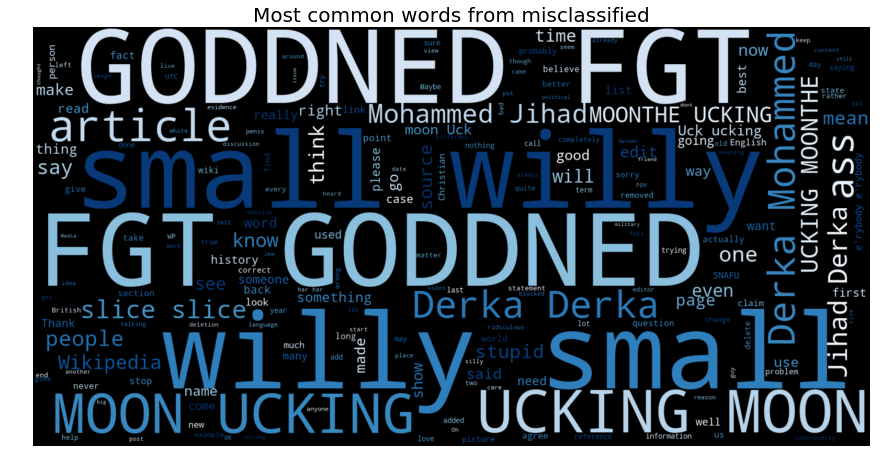

In [33]:
#Misclassified 494 as non-toxic which were actually toxic
#Extract those comments classifier went wrong
commentCheck=test_combined[(test_combined.toxic==1) & (Toxic_LR==0)].comment_text
#Created word cloud of those comments 
neg_Check = pd.Series(commentCheck).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

- We want to analyze why the model couldn't recognize these words. Were they not present in the training set? 
- In order to analyze we first need to pass these raw comment strings through same tokenizer and check the common tokens.

In [ ]:
wrongWords=tokenize(neg_Check)
stop_words=stopwords.words('English')
wrongWords=[w for w in wrongWords if w not in stop_words]
cntr=Counter(wrongWords)
cntr.most_common(20)

ucking is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

In [ ]:
neg_text_train=train['comment_text'].str.cat(sep=' ')
cntr_train=Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

It is interesting to note that this token wasn't common in our training set. That explains why our model couldn't learn it. 
It also gives us some food for thought on how we can improve our model further.

Let's see the features and whether this word had a high feature importance

### 👓 Visual check how logistic learns

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None: plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve( estimator, 
                                    X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="olive",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
title = "Learning Curves (Logistic regression) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(class_weight="balanced")
plot_learning_curve(estimator, title, X_train, train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

### Visualize features causing negative words

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(20, 5))
    colors = ["blue" if c < 0 else "red" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

In [ ]:
%matplotlib inline
print("                          Top and Bottom 20 features              ")
plot_coefficients(clf2, vector.get_feature_names())

## Future Improvements

THINGS THAT WE COULD TRY - PLACEHOLDER

## Reference

PLACEHOLDER